OCT IMAGE CLASSIFICATION PROJECT - NOTEBOOK 3: DATA AUGMENTATION & PREPROCESSING

✓ Segmented images directory: /kaggle/input/segmentedimages
✓ Image size: 224x224
✓ Batch size: 32

[1/6] Loading and exploring dataset...

Dataset Distribution:
Train: {'DRUSEN': 1995, 'CNV': 8847, 'NORMAL': 6242, 'DME': 2686}
Val:   {'DRUSEN': 1, 'CNV': 1, 'NORMAL': 2}
Test:  {'DRUSEN': 61, 'CNV': 54, 'NORMAL': 59, 'DME': 52}

Total - Train: 19770, Val: 4, Test: 226

[2/6] Defining augmentation transforms...
✓ Augmentation transforms defined
  Training augmentations: Flip, Rotate, Noise, Blur, Brightness/Contrast, Elastic
  Val/Test transforms: Resize + Normalize only

[3/6] Creating custom dataset class...
✓ Custom dataset class created

[4/6] Creating datasets and dataloaders...
✓ Datasets created:
  Train dataset: 19770 images
  Val dataset:   4 images
  Test dataset:  226 images

✓ Dataloaders created:
  Train batches: 618
  Val batches:   1
  Test batches:  8

[5/6] Visualizing augmented samples...

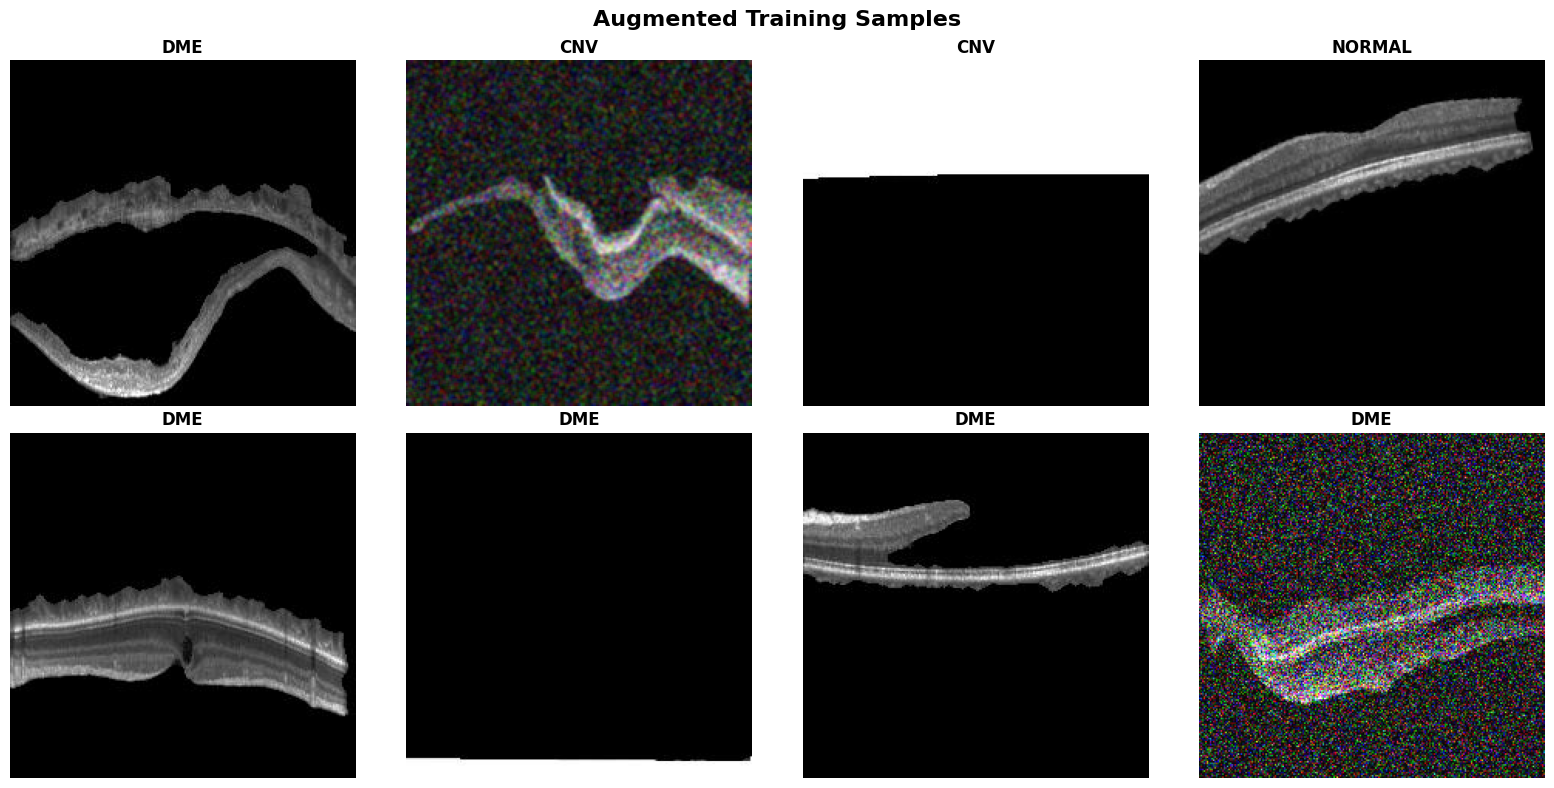


[6/6] Saving dataset information...
✓ Saved class distribution visualization


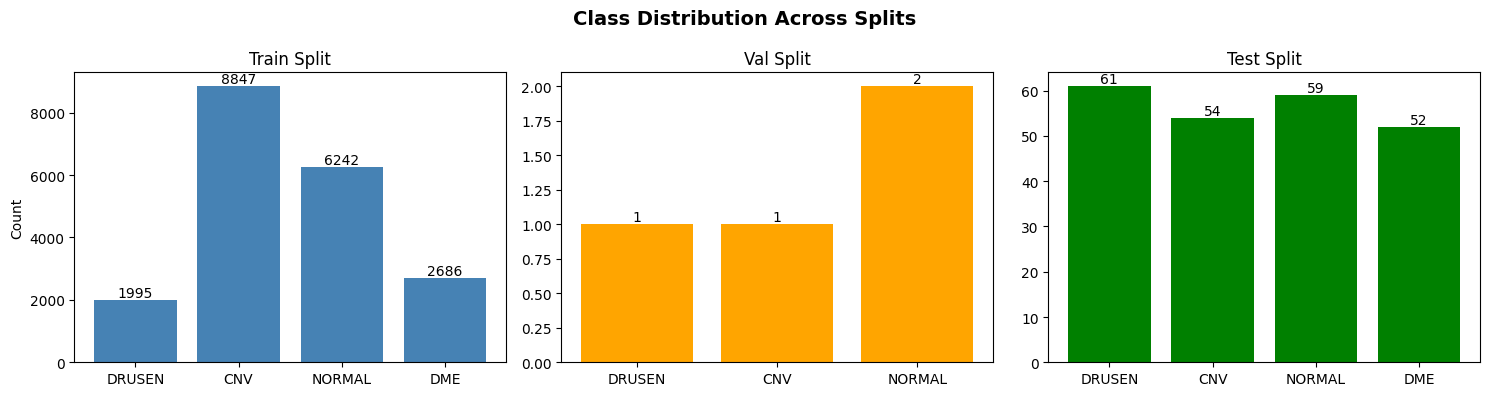


DATA AUGMENTATION & PREPROCESSING - SUMMARY REPORT

1. INPUT DATASET
   - Segmented images directory: /kaggle/input/segmentedimages
   - Image size: 224x224
   - Training classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']

2. DATASET STATISTICS
   Train split:   19770 images
   Val split:     4 images
   Test split:    226 images
   Total:         20000 images

3. CLASS DISTRIBUTION
   Train: {'DRUSEN': 1995, 'CNV': 8847, 'NORMAL': 6242, 'DME': 2686}
   Val:   {'DRUSEN': 1, 'CNV': 1, 'NORMAL': 2}
   Test:  {'DRUSEN': 61, 'CNV': 54, 'NORMAL': 59, 'DME': 52}

4. AUGMENTATION STRATEGY
   Training Augmentations:
   ✓ Horizontal Flip (50%)
   ✓ Vertical Flip (50%)
   ✓ Rotation (±20°, 50%)
   ✓ Gaussian Noise (20%)
   ✓ Gaussian Blur (20%)
   ✓ Brightness/Contrast ±20% (30%)
   ✓ Elastic Transform (20%)
   Val/Test Transforms:
   ✓ Resize to 224x224
   ✓ Normalization (mean=0.5, std=0.5)
   ✓ No augmentation

5. DATALOADER CONFIGURATION
   Batch size: 32
   Num workers: 4
   Train batches: 618
  

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("OCT IMAGE CLASSIFICATION PROJECT - NOTEBOOK 3: DATA AUGMENTATION & PREPROCESSING")
print("="*80)

# ========== CONFIGURATION ==========
SEGMENTED_IMG_DIR = '/kaggle/input/segmentedimages'
OUTPUT_DIR = '/kaggle/working'
TRAIN_DIR = os.path.join(SEGMENTED_IMG_DIR, 'train')
VAL_DIR = os.path.join(SEGMENTED_IMG_DIR, 'val')
TEST_DIR = os.path.join(SEGMENTED_IMG_DIR, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"\n✓ Segmented images directory: {SEGMENTED_IMG_DIR}")
print(f"✓ Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"✓ Batch size: {BATCH_SIZE}")

# ========== 1. LOAD AND EXPLORE DATASET ==========
print("\n[1/6] Loading and exploring dataset...")

def count_images(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            counts[cls] = len(images)
    return counts

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

print("\nDataset Distribution:")
print(f"Train: {train_counts}")
print(f"Val:   {val_counts}")
print(f"Test:  {test_counts}")

total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())
print(f"\nTotal - Train: {total_train}, Val: {total_val}, Test: {total_test}")

# ========== 2. DEFINE DATA AUGMENTATION TRANSFORMS ==========
print("\n[2/6] Defining augmentation transforms...")

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.GaussNoise(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ElasticTransform(p=0.2),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
], is_check_shapes=False)

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2(),
], is_check_shapes=False)

print("✓ Augmentation transforms defined")
print(f"  Training augmentations: Flip, Rotate, Noise, Blur, Brightness/Contrast, Elastic")
print(f"  Val/Test transforms: Resize + Normalize only")

# ========== 3. CUSTOM DATASET CLASS ==========
print("\n[3/6] Creating custom dataset class...")

class OCTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        
        classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for img_name in images:
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            image = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

print("✓ Custom dataset class created")

# ========== 4. CREATE DATASETS AND DATALOADERS ==========
print("\n[4/6] Creating datasets and dataloaders...")

train_dataset = OCTDataset(TRAIN_DIR, transform=train_transform)
val_dataset = OCTDataset(VAL_DIR, transform=val_test_transform)
test_dataset = OCTDataset(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"✓ Datasets created:")
print(f"  Train dataset: {len(train_dataset)} images")
print(f"  Val dataset:   {len(val_dataset)} images")
print(f"  Test dataset:  {len(test_dataset)} images")
print(f"\n✓ Dataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# ========== 5. VISUALIZE AUGMENTED SAMPLES ==========
print("\n[5/6] Visualizing augmented samples...")

def visualize_batch(dataloader, n_samples=8):
    batch_images, batch_labels = next(iter(dataloader))
    batch_images = batch_images * 0.5 + 0.5
    batch_images = torch.clamp(batch_images, 0, 1)
    idx_to_class = train_dataset.idx_to_class
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Augmented Training Samples', fontsize=16, fontweight='bold')
    for idx in range(min(n_samples, len(batch_images))):
        ax = axes[idx // 4, idx % 4]
        img = batch_images[idx].permute(1, 2, 0).numpy()
        label = batch_labels[idx].item()
        cls_name = idx_to_class[label]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'{cls_name}', fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'augmented_samples.png'), dpi=300, bbox_inches='tight')
    print("✓ Saved augmented samples visualization")
    plt.show()

visualize_batch(train_loader, n_samples=8)

# ========== 6. SAVE DATASET INFO & STATISTICS ==========
print("\n[6/6] Saving dataset information...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].bar(train_counts.keys(), train_counts.values(), color='steelblue')
axes[0].set_title('Train Split')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values()):
    axes[0].text(i, v, str(v), ha='center', va='bottom')
axes[1].bar(val_counts.keys(), val_counts.values(), color='orange')
axes[1].set_title('Val Split')
for i, v in enumerate(val_counts.values()):
    axes[1].text(i, v, str(v), ha='center', va='bottom')
axes[2].bar(test_counts.keys(), test_counts.values(), color='green')
axes[2].set_title('Test Split')
for i, v in enumerate(test_counts.values()):
    axes[2].text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
print("✓ Saved class distribution visualization")
plt.show()

summary_report = f"""
{'='*80}
DATA AUGMENTATION & PREPROCESSING - SUMMARY REPORT
{'='*80}

1. INPUT DATASET
   - Segmented images directory: {SEGMENTED_IMG_DIR}
   - Image size: {IMG_SIZE}x{IMG_SIZE}
   - Training classes: {list(train_dataset.idx_to_class.values())}

2. DATASET STATISTICS
   Train split:   {total_train} images
   Val split:     {total_val} images
   Test split:    {total_test} images
   Total:         {total_train + total_val + total_test} images

3. CLASS DISTRIBUTION
   Train: {train_counts}
   Val:   {val_counts}
   Test:  {test_counts}

4. AUGMENTATION STRATEGY
   Training Augmentations:
   ✓ Horizontal Flip (50%)
   ✓ Vertical Flip (50%)
   ✓ Rotation (±20°, 50%)
   ✓ Gaussian Noise (20%)
   ✓ Gaussian Blur (20%)
   ✓ Brightness/Contrast ±20% (30%)
   ✓ Elastic Transform (20%)
   Val/Test Transforms:
   ✓ Resize to {IMG_SIZE}x{IMG_SIZE}
   ✓ Normalization (mean=0.5, std=0.5)
   ✓ No augmentation
        
        5. DATALOADER CONFIGURATION
           Batch size: {BATCH_SIZE}
           Num workers: {NUM_WORKERS}
           Train batches: {len(train_loader)}
           Val batches: {len(val_loader)}
           Test batches: {len(test_loader)}
        
        6. OUTPUT FILES
           - augmented_samples.png       (Sample augmented images)
           - class_distribution.png      (Class distribution across splits)
           - preprocessing_report.txt    (This report)
        
        7. NEXT STEPS
           - Proceed to Notebook 4 for model training
           - Use train_loader, val_loader, test_loader for training pipeline
           - Saved dataloaders are ready for PyTorch training
        
        {'='*80}
        """
        
        with open(os.path.join(OUTPUT_DIR, 'preprocessing_report.txt'), 'w') as f:
            f.write(summary_report)
        
        print(summary_report)
        
        import json
        dataloader_info = {
            'train_batches': len(train_loader),
            'val_batches': len(val_loader),
            'test_batches': len(test_loader),
            'batch_size': BATCH_SIZE,
            'image_size': IMG_SIZE,
            'num_classes': len(train_dataset.idx_to_class),
            'classes': list(train_dataset.idx_to_class.values()),
            'train_samples': total_train,
            'val_samples': total_val,
            'test_samples': total_test
        }
        
        with open(os.path.join(OUTPUT_DIR, 'dataloader_info.json'), 'w') as f:
            json.dump(dataloader_info, f, indent=4)
        
        print("\n" + "="*80)
        print("NOTEBOOK 3 COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\n✓ Generated output files:")
print(f"  1. augmented_samples.png       (Augmentation visualization)")
print(f"  2. class_distribution.png      (Class distribution chart)")
print(f"  3. preprocessing_report.txt    (Summary report)")
print(f"  4. dataloader_info.json        (Dataloader metadata)")
print(f"\n📌 NEXT STEP: Run Notebook 4 for Model Training")
print("="*80)
